# Round trip time box plots

Depends on the output from the [ExtractRawData](./ExtractRawData.ipynb) notebook.

For all the successful calls, For both clients (Alice, Bob) find the measured RTT values from the WebRTC stat `remote-inbound-rtp` for both video and audio.

Plot the data.

Outputs the following:

- `output_folder/RttPlotDf.csv`. The data used for the plot with headers: `scenario, client, mediaType, RTT`
- Box plot, RTT Video [BoxPlotRttVideo.png](./output_folder/BoxPlotRttVideo.png)
- Box plot, RTT Video [BoxPlotRttVideo.svg](./output_folder/BoxPlotRttVideo.svg)
- Box plot, RTT Video log scale [BoxPlotRttVideoLogScale.png](./output_folder/BoxPlotRttVideoLogScale.png)
- Box plot, RTT Video log scale [BoxPlotRttVideoLogScale.svg](./output_folder/BoxPlotRttVideoLogScale.svg)
- Box plot, RTT Audio [BoxPlotRttAudio.png](./output_folder/BoxPlotRttAudio.png)
- Box plot, RTT Audio [BoxPlotRttAudio.svg](./output_folder/BoxPlotRttAudio.svg)
- Box plot, RTT Audio log scale [BoxPlotRttAudioLogScale.png](./output_folder/BoxPlotRttAudioLogScale.png)
- Box plot, RTT Audio log scale [BoxPlotRttAudioLogScale.svg](./output_folder/BoxPlotRttAudioLogScale.svg)
- Box plot, RTT Video log scale (Close up) [BoxPlotRttVideoCloseUpLogScale.png](./output_folder/BoxPlotRttVideoCloseUpLogScale.png)
- Box plot, RTT Video log scale (Close up) [BoxPlotRttVideoCloseUpLogScale.svg](./output_folder/BoxPlotRttVideoCloseUpLogScale.svg)
- Box plot, RTT Audio log scale (Close up) [BoxPlotRttAudioCloseUpLogScale.png](./output_folder/BoxPlotRttAudioCloseUpLogScale.png)
- Box plot, RTT Audio log scale (Close up) [BoxPlotRttAudioCloseUpLogScale.svg](./output_folder/BoxPlotRttAudioCloseUpLogScale.svg)


In [1]:
import sys
from dotenv import load_dotenv
from datetime import datetime, timedelta
import pandas as pd
import os
import json
import logging
import matplotlib.pyplot as plt
import helperFunctions as hf
import numpy as np

hf.setup()

callAndOutcomeFile = "output_folder/UniqueCallsAndOutcomes.csv"
outputFolder = "output_folder/"


if not os.path.exists(outputFolder):

   # Create a new directory because it does not exist
   os.makedirs(outputFolder)
   logging.info(f"The directory \"{outputFolder}\" is created!")

In [2]:
plotDf = pd.DataFrame(columns=["scenario", "client", "mediaType", "RTT"])

callsDf = pd.read_csv(callAndOutcomeFile)

logging.info(f"shape of calls: {callsDf.shape}")

# filter for calls with state success
successCallsDf = callsDf.loc[callsDf["logging_type"] == "COMMAND_SESSION_SUCCESS"]

logging.info(f"shape of success full calls: {successCallsDf.shape}")



for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  logging.info(f"Starting on scenario {s}, alice: {a}, bob: {b}")

  # filter for calls with scenario_type s
  scenarioCallsDf = successCallsDf.loc[successCallsDf["scenario_type"] == s]

  # get list of room_ids in scenarioCallsDf
  roomIds = scenarioCallsDf["room_id"].unique()

  reportForClientA = pd.read_csv(f"output_folder/rawReport/{a}.csv")
  reportForClientVideoA = reportForClientA[(reportForClientA["type"] == "remote-inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "video") ]
  dataVideoA = pd.DataFrame(columns=["scenario", "client", "mediaType", "RTT"]).assign(RTT=reportForClientVideoA["roundTripTime"])
  dataVideoA = dataVideoA.assign(scenario=s, client=a, mediaType="video")

  reportForClientAudioA = reportForClientA[(reportForClientA["type"] == "remote-inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "audio") ]
  dataAudioA = pd.DataFrame(columns=["scenario", "client", "mediaType", "RTT"]).assign(RTT=reportForClientAudioA["roundTripTime"])
  dataAudioA = dataAudioA.assign(scenario=s, client=a, mediaType="audio")

  reportForClientB = pd.read_csv(f"output_folder/rawReport/{b}.csv")
  reportForClientVideoB = reportForClientB[(reportForClientB["type"] == "remote-inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "video") ]
  dataVideoB = pd.DataFrame(columns=["scenario", "client", "mediaType", "RTT"]).assign(RTT=reportForClientVideoB["roundTripTime"])
  dataVideoB = dataVideoB.assign(scenario=s, client=b, mediaType="video")

  reportForClientAudioB = reportForClientA[(reportForClientA["type"] == "remote-inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "audio") ]
  dataAudioB = pd.DataFrame(columns=["scenario", "client", "mediaType", "RTT"]).assign(RTT=reportForClientAudioB["roundTripTime"])
  dataAudioB = dataAudioB.assign(scenario=s, client=b, mediaType="audio")

  plotDf = pd.concat([plotDf, dataVideoA, dataAudioA, dataVideoB, dataAudioB], ignore_index=True)

logging.info(f"plotDf shape: {plotDf.shape}")

# save plotDf to csv
plotDf.to_csv(f"{outputFolder}/RttPlotDf.csv",index=False, header=True, encoding='utf-8', mode='w')


2023-02-09 10:33:09 INFO     shape of calls: (19222, 7) 
2023-02-09 10:33:09 INFO     shape of success full calls: (19064, 7) 
2023-02-09 10:33:09 INFO     Starting on scenario 1, alice: c1-Normal, bob: d1-Normal 
2023-02-09 10:33:15 INFO     Starting on scenario 2, alice: c2-TorNormal, bob: d2-TorNormal 
2023-02-09 10:33:20 INFO     Starting on scenario 3, alice: c3-TorEurope, bob: d3-TorEurope 
2023-02-09 10:33:25 INFO     Starting on scenario 4, alice: c4-TorScandinavia, bob: d4-TorScandinavia 
2023-02-09 10:33:29 INFO     Starting on scenario 5, alice: c6-Lokinet, bob: d6-Lokinet 
2023-02-09 10:33:32 INFO     Starting on scenario 6, alice: c1-Normal, bob: d2-TorNormal 
2023-02-09 10:33:37 INFO     Starting on scenario 7, alice: c2-TorNormal, bob: d1-Normal 
2023-02-09 10:33:43 INFO     Starting on scenario 8, alice: c1-Normal, bob: d3-TorEurope 
2023-02-09 10:33:48 INFO     Starting on scenario 9, alice: c3-TorEurope, bob: d1-Normal 
2023-02-09 10:33:53 INFO     Starting on scenari

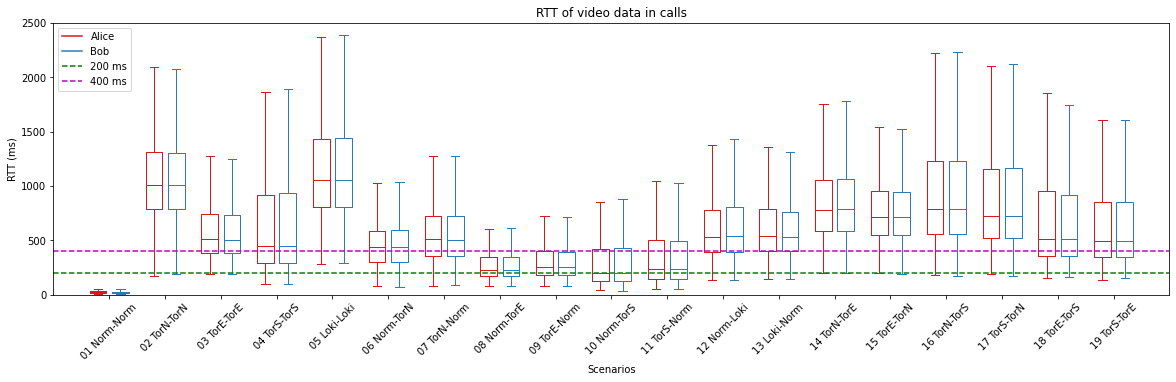

In [9]:
dataA = []
dataB = []
for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "video") & (plotDf["client"] == a)]["RTT"].values * 1000)
  dataB.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "video") & (plotDf["client"] == b)]["RTT"].values * 1000)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.title("RTT of video data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('RTT (ms)')
plt.ylim(0, 2500)

plt.axhline(y = 200, color = 'g', linestyle = 'dashed', label = "200 ms")
plt.axhline(y = 400, color = 'm', linestyle = 'dashed', label = "400 ms")


plt.legend(loc="upper left")
plt.savefig("output_folder/BoxPlotRttVideo.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotRttVideo.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

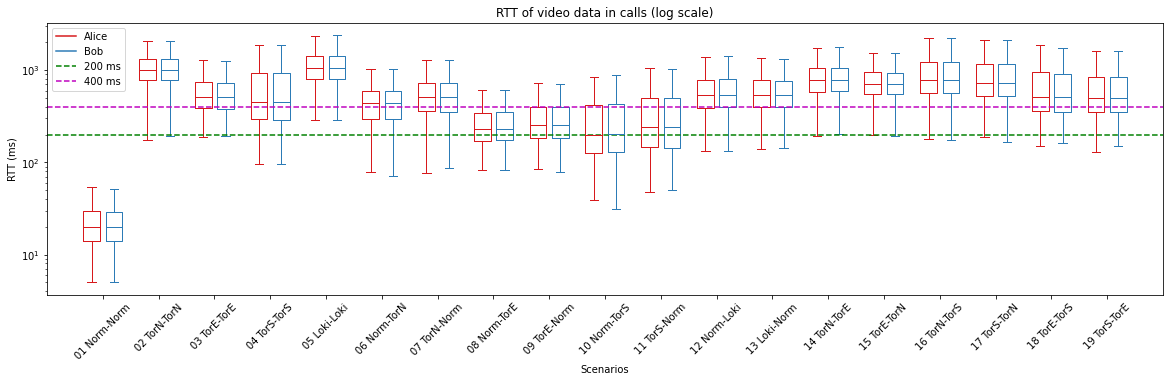

In [4]:
dataA = []
dataB = []
for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "video") & (plotDf["client"] == a)]["RTT"].values * 1000)
  dataB.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "video") & (plotDf["client"] == b)]["RTT"].values * 1000)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.title("RTT of video data in calls (log scale)")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('RTT (ms)')
plt.yscale('log',base=10)

plt.axhline(y = 200, color = 'g', linestyle = 'dashed', label = "200 ms")
plt.axhline(y = 400, color = 'm', linestyle = 'dashed', label = "400 ms")


plt.legend(loc="upper left")
plt.savefig("output_folder/BoxPlotRttVideoLogScale.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotRttVideoLogScale.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

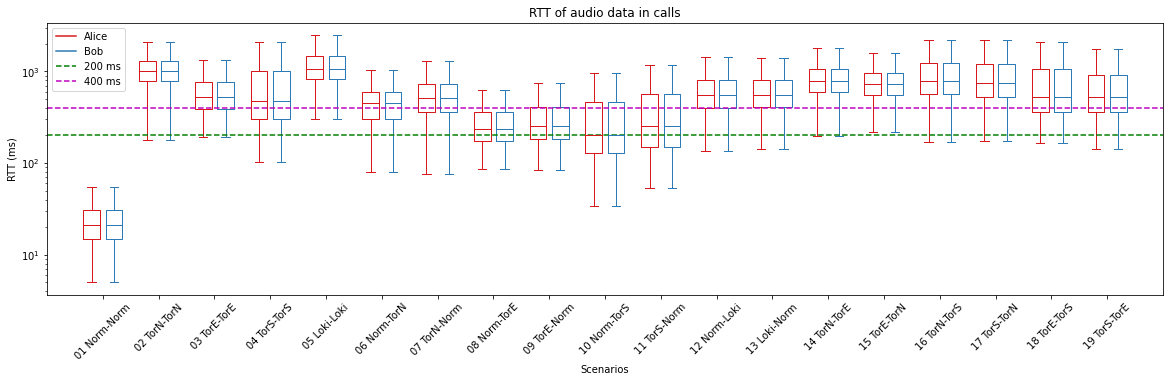

In [5]:
dataA = []
dataB = []
for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == a)]["RTT"].values * 1000)
  dataB.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == b)]["RTT"].values * 1000)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.title("RTT of audio data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('RTT (ms)')
plt.yscale('log',base=10)

plt.axhline(y = 200, color = 'g', linestyle = 'dashed', label = "200 ms")
plt.axhline(y = 400, color = 'm', linestyle = 'dashed', label = "400 ms")


plt.legend(loc="upper left")
plt.savefig("output_folder/BoxPlotRttAudio.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotRttAudio.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

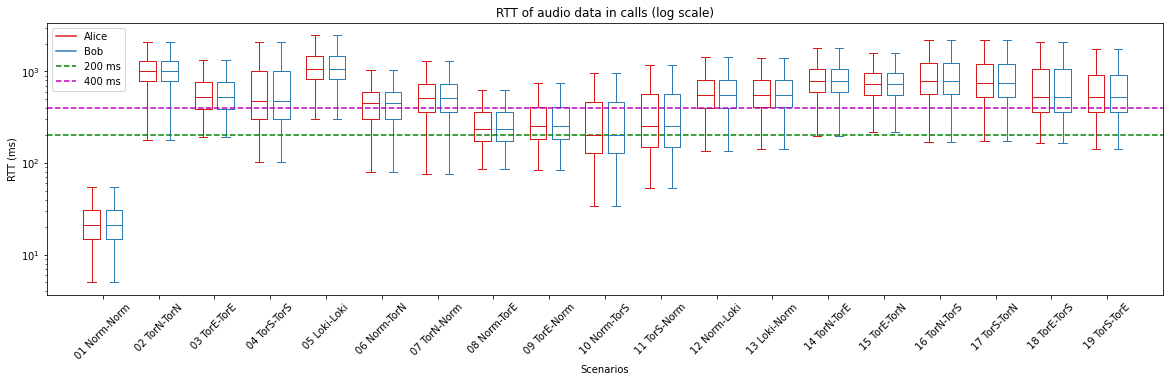

In [6]:
dataA = []
dataB = []
for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == a)]["RTT"].values * 1000)
  dataB.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == b)]["RTT"].values * 1000)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.title("RTT of audio data in calls (log scale)")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('RTT (ms)')
plt.yscale('log',base=10) 

plt.axhline(y = 200, color = 'g', linestyle = 'dashed', label = "200 ms")
plt.axhline(y = 400, color = 'm', linestyle = 'dashed', label = "400 ms")

plt.legend(loc="upper left")
plt.savefig("output_folder/BoxPlotRttAudioLogScale.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotRttAudioLogScale.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

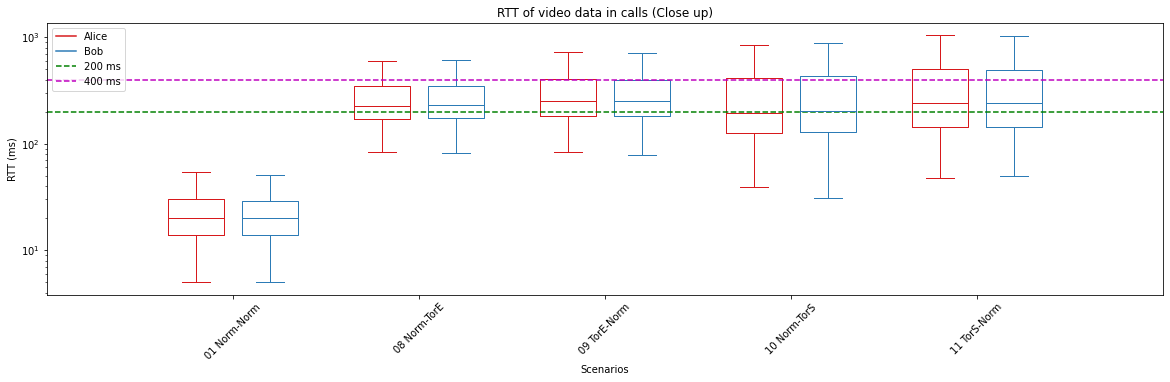

In [7]:
dataA = []
dataB = []
for i in [1,8,9,10,11]:
  s = hf.scenarios[i-1]["scenario"]
  a = hf.scenarios[i-1]["alice"]
  b = hf.scenarios[i-1]["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "video") & (plotDf["client"] == a)]["RTT"].values * 1000)
  dataB.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "video") & (plotDf["client"] == b)]["RTT"].values * 1000)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.title("RTT of video data in calls (Close up)")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels([1,8,9,10,11])
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('RTT (ms)')
plt.yscale('log',base=10)

plt.axhline(y = 200, color = 'g', linestyle = 'dashed', label = "200 ms")
plt.axhline(y = 400, color = 'm', linestyle = 'dashed', label = "400 ms")


plt.legend(loc="upper left")
plt.savefig("output_folder/BoxPlotRttVideoCloseUpLogScale.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotRttVideoCloseUpLogScale.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

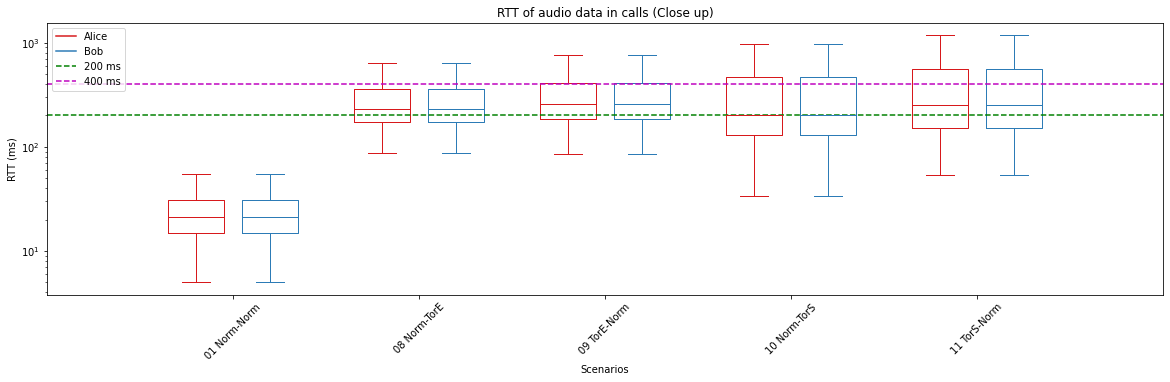

In [8]:
dataA = []
dataB = []
for i in [1,8,9,10,11]:
  s = hf.scenarios[i-1]["scenario"]
  a = hf.scenarios[i-1]["alice"]
  b = hf.scenarios[i-1]["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == a)]["RTT"].values * 1000)
  dataB.append(plotDf.loc[(plotDf["scenario"] == s) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == b)]["RTT"].values * 1000)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.title("RTT of audio data in calls (Close up)")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels([1,8,9,10,11])
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('RTT (ms)')
plt.yscale('log',base=10)

plt.axhline(y = 200, color = 'g', linestyle = 'dashed', label = "200 ms")
plt.axhline(y = 400, color = 'm', linestyle = 'dashed', label = "400 ms")


plt.legend(loc="upper left")
plt.savefig("output_folder/BoxPlotRttAudioCloseUpLogScale.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotRttAudioCloseUpLogScale.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()